In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

In [6]:
img_height, img_width = 180, 180 
face_images_dir = "data/faces_images"
images_dir = "data/images"
annotations_dir = "data/annotations"

In [22]:
# for each image in the images folder, find the equivalent xml file and add all faces to the directory depending on 
# its class (mask_weared_incorrect, with_mask, without_mask)
counter = 0
directory = os.fsencode(images_dir)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    tree = ET.parse(annotations_dir + "/" + filename.replace(".png", ".xml"))
    root = tree.getroot()
    for child in root:
        # each object represents a face so save a cropped + resized version version
        if child.tag == "object":
            new_dir = face_images_dir + "/" + child.find("name").text
            xmin = child.find("bndbox").find("xmin").text
            xmax = child.find("bndbox").find("xmax").text
            ymin = child.find("bndbox").find("ymin").text
            ymax = child.find("bndbox").find("ymax").text
            Image.open(images_dir + "/" + filename).crop(box=(int(xmin), int(ymin), int(xmax), int(ymax))).resize((180, 180)).save(new_dir + "/image" + str(counter) + ".png")
            counter += 1


In [56]:
# don't use the last layers for classification, since vgg19 can classify 1000 different objects
vgg19 = keras.applications.vgg19.VGG19(include_top=False, input_shape=(180, 180, 3))
# freeze the parameters in the vgg19 model
vgg19.trainable = False
# describes the input layer (image size = 180x180x3)
input = keras.Input(shape=(180, 180, 3))
# describes the output layer
output = keras.applications.vgg19.preprocess_input(input)
preprocess = keras.Model(inputs=input, outputs=output)

# remember that layers are just functions that take in the previous layer as a vector and apply some transformation (usually activation(w*x+b))
# to obtain the current layer
model = keras.models.Sequential([
    keras.layers.Input(shape=(180, 180, 3)),
    # note: image preprocessing layers only apply during training
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1),
    preprocess,

    vgg19,
    # returns average over each 2-D matrix slice in the input volume i.e. if one input (not including batch size)
    # has dimensions (m, n, p), then the resulting output would be a tensor with dimensions (p), so it serves as a flatten operation
    # while saving # of parameters
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    # softmax so that the model automatically outputs probabilities instead of logits
    keras.layers.Dense(3, activation="softmax")
])

In [57]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 model_6 (Functional)        (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                             

In [58]:
# use a seed so that the order in which images are read is deterministic even if it's shuffled
# validation split simply takes the first 0.2*len images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    face_images_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    # note: images are read by the dimension order (height, width, channels)
    image_size=(img_height, img_width))

Found 4072 files belonging to 3 classes.
Using 3258 files for training.


In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    face_images_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width))

Found 4072 files belonging to 3 classes.
Using 814 files for validation.


In [60]:
# the encoding mechanism
val_ds.class_names


['mask_weared_incorrect', 'with_mask', 'without_mask']

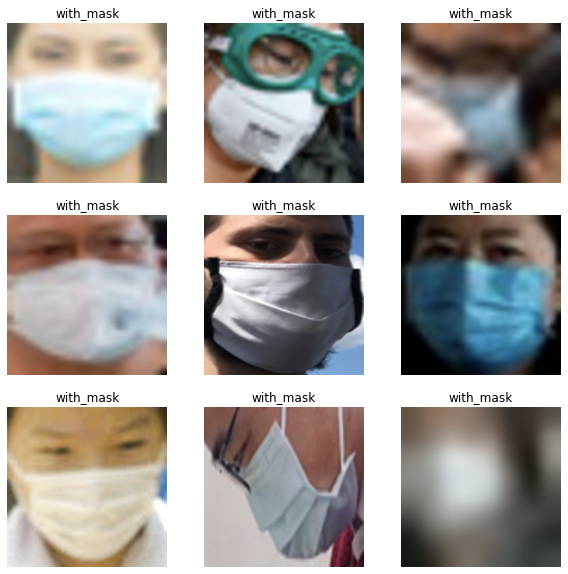

In [61]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [62]:
# test out the model with a sample batch (of 32 images)
image_batch, label_batch = next(iter(train_ds))
# feature_batch = model(image_batch)
# print(feature_batch.shape)
label_batch


<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 2])>

In [63]:
model.compile(keras.optimizers.Adam(learning_rate=0.001),
            # we're already using probabilities so don't set from_logits
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [64]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [65]:
hist= model.fit(train_ds, epochs = 120, 
    validation_data = val_ds,
    callbacks=[early_stop])

Epoch 1/120
102/102 [==============================] - 321s 3s/step - loss: 1.0814 - accuracy: 0.7480 - val_loss: 0.5556 - val_accuracy: 0.8624
Epoch 2/120
102/102 [==============================] - 331s 3s/step - loss: 0.5205 - accuracy: 0.8493 - val_loss: 0.3877 - val_accuracy: 0.9103
Epoch 3/120
102/102 [==============================] - 360s 4s/step - loss: 0.4047 - accuracy: 0.8846 - val_loss: 0.2931 - val_accuracy: 0.9177
Epoch 4/120
102/102 [==============================] - 362s 4s/step - loss: 0.3369 - accuracy: 0.8969 - val_loss: 0.2575 - val_accuracy: 0.9287
Epoch 5/120
102/102 [==============================] - 359s 4s/step - loss: 0.2934 - accuracy: 0.9085 - val_loss: 0.2077 - val_accuracy: 0.9373
Epoch 6/120
102/102 [==============================] - 335s 3s/step - loss: 0.2689 - accuracy: 0.9131 - val_loss: 0.1906 - val_accuracy: 0.9484
Epoch 7/120
102/102 [==============================] - 452s 4s/step - loss: 0.2447 - accuracy: 0.9227 - val_loss: 0.2011 - val_accuracy:

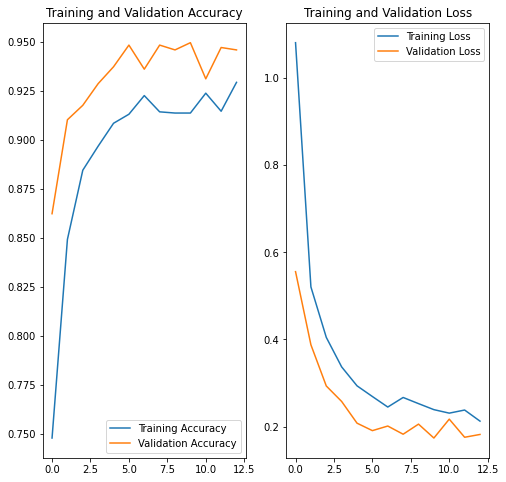

In [66]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
model.save("model.h5")